In [22]:
import os
import torch

# path = "/home/lnhang/Final_cases/PH_1p0"
# path = "/home/lnhang/Final_cases/S809_14degree_Re2e6"
path = "/home/lnhang/Final_cases/CBFS13700_SA"
save_file = "/home/lnhang/Final_cases/data_loader"
time_step = "converged_target"
final_path = os.path.join(path, str(time_step))

def read_openfoam_field_to_tensor(path, field_name, patch_name="internalField"):
        """
        read the file from the given path and return the field tensor
        """
        file_path = os.path.join(path, field_name)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        find_patch = False
        start = False
        data = []

        for line in lines:
            if start and find_patch:
                if line.startswith(')'):
                    break
                # 如果不是注释或空行，则处理数据
                stripped_line = line.strip().replace('(', '').replace(')', '')
                if not stripped_line.startswith("//") and stripped_line:
                    # 将每个值映射到浮点数，然后转换成列表
                    data.append(list(map(float, stripped_line.split())))
            elif patch_name in line:
                find_patch = True
            elif find_patch and "(" in line:
                start = True

        field = torch.tensor(data)
        return field

In [23]:
chi = read_openfoam_field_to_tensor(final_path, "chiML", "internalField")
# fw = read_openfoam_field_to_tensor(final_path, "fwML", "internalField")
Stilda = read_openfoam_field_to_tensor(final_path, "StildaNorm", "internalField")
r = read_openfoam_field_to_tensor(final_path, "rML", "internalField")

beta = read_openfoam_field_to_tensor(final_path, "betaFieldInversion", "internalField")

In [24]:
from collections import deque
import re
from vtk.util.numpy_support import vtk_to_numpy
import vtk
import numpy as np


def create_triangles(path):
        """
        This function creates triangles for the mesh from the given cell connectivity information.

        To ensure that no edges are used more than twice, which can lead to overlapping triangles
        and inconsistencies in the mesh, the following rules are applied:

        1. If one of the neighbors is in created_indices, continue 

        2. If all neighbors not in created_indices, create triangles

        """

        created_indices = set()

        visited_indices = set()

        queue = deque()

        cell_connectivity = get_cell_connectivity(path)

        triangles = []

        # start from the first cell
        start_cell = list(cell_connectivity.keys())[0]
        queue.append(start_cell)
        visited_indices.add(start_cell)

        while queue:
            current_cell = queue.popleft()
            neighbors = cell_connectivity[current_cell]

            for neighbor in neighbors:
                if neighbor not in visited_indices:
                    queue.append(neighbor)
                    visited_indices.add(neighbor)

            if not any(neighbor in created_indices for neighbor in neighbors):
                # All neighbors are not in created_indices
                # Create triangles
                for i in range(len(neighbors)):
                    for j in range(i+1, len(neighbors)):
                        triangles.append([current_cell, neighbors[i], neighbors[j]])
                created_indices.add(current_cell)
            else:
                continue

        return triangles
    
def get_cell_connectivity(path):
    """
    get the connectivity of the cells

    input:
        - path: the path of the case

    output:
        - connectivity: a dict with the cells as keys and the neighbor cells as values : {cell: [cell1, cell2]}
    """
    # read the owner and neighbour file
    owner, neighbor, nInternalFaces = read_mesh_information(path)

    # for each cell, get the neighbor cells
    connectivity = {}
    for i in range(nInternalFaces):
        cell1 = owner[i]
        cell2 = neighbor[i]
        if cell1 not in connectivity:
            connectivity[cell1] = [cell2]
        else:
            connectivity[cell1].append(cell2)

        if cell2 not in connectivity:
            connectivity[cell2] = [cell1]
        else:
            connectivity[cell2].append(cell1)

    return connectivity

def read_mesh_information(path):
    """
    Read the owner and neighbor file

    input:
        - path: the path of the case

    output:
        - owner: the owner of the cells
        - neighbor: the neighbor of the cells
        - nInternalFaces: the number of internal faces
    """
    # read the owner file
    owner_file = os.path.join(path, "constant/polyMesh/owner")
    neighbor_file = os.path.join(path, "constant/polyMesh/neighbour")

    # read the nInternalFaces
    nInternalFaces = 0
    with open(neighbor_file, "r") as f:
        for line in f:
            if "nInternalFaces" in line:
                match = re.search("nInternalFaces:\s*(\d+)", line)
                if match:
                    nInternalFaces = int(match.group(1))
                break

    # use the nInternalFaces to read the owner and neighbor
    owner = []
    neighbor = []

    with open(owner_file, "r") as f:
        start_reading = False
        for line in f:
            line = line.strip()
            if line.startswith("("):
                start_reading = True
                continue
            elif line.startswith(")"):
                break
            if start_reading:
                owner.extend([int(i) for i in line.split()])

    with open(neighbor_file, "r") as f:
        start_reading = False
        for line in f:
            line = line.strip()
            if line.startswith("("):
                start_reading = True
                continue
            elif line.startswith(")"):
                break
            if start_reading:
                neighbor.extend([int(i) for i in line.split()])

    if nInternalFaces == 0:
        nInternalFaces = len(neighbor)

    return owner, neighbor, nInternalFaces

def get_internal_coordinates(path):
    """
    Get the cell center of the internal cells

    input:
        - path: the path of the case

    output:
        - Internal_coordinates: the coordinates of the internal cells
    """
    # vtk file path 
    # if not exist, create the vtk file
    if not os.path.exists(path+"/VTK"):
        os.system("cd "+path+" && foamToVTK")

    vtk_file = get_dir_file_name(path+"/VTK/")
    vtk_path = os.path.join(path, "VTK/"+vtk_file)

    # load the internal.vtu
    internal_path = os.path.join(vtk_path, "internal.vtu")
    Internal_coordinates = get_vtu_cell_center(internal_path)
    return Internal_coordinates

def get_dir_file_name(path):
    """
    Get the vtk file name

    input:
        - path: the path of the case

    output:
        - vtk_file: the name of the vtk file
    """
    # Initialize variable for the directory name
    dir_name = None

    # Regex pattern to match folder ending with _<number>
    pattern = re.compile(r"_\d+$")

    # Iterate over the items in the path
    for item in os.listdir(path):
        # Check if the item is a directory and matches the pattern
        if os.path.isdir(os.path.join(path, item)) and pattern.search(item):
            dir_name = item
            break

    # Handling the case where no matching directory is found
    if dir_name is None:
        raise FileNotFoundError("No directory matching the pattern found")

    return dir_name

def get_vtu_cell_center(path):
    """
    Get the cell center of the vtu file

    input:
        - path: the path of the vtu file

    output:
        - cells_coordinates: the coordinates of the cells
    """
    # load the mesh
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(path)
    reader.Update()
    vtu_data = reader.GetOutput()

    # get coordinates
    cellCentersFilter = vtk.vtkCellCenters()
    cellCentersFilter.SetInputData(vtu_data)
    cellCentersFilter.Update()

    cellCenters = cellCentersFilter.GetOutput()
    np_cellCenters = vtk_to_numpy(cellCenters.GetPoints().GetData())

    x = np_cellCenters[:, 0]
    y = np_cellCenters[:, 1]

    cell_coordinates = np.vstack((x, y)).T

    return cell_coordinates


triangle = create_triangles(path)
internal_coordinates = get_internal_coordinates(path)



In [25]:
from matplotlib.tri import Triangulation
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib import pyplot as plt

def plot_streamlines(U, coordinates, ax, steps=1000, step_size=1, back=False):
        
        from scipy.interpolate import LinearNDInterpolator
        
        
        def velocity_interpolator(U, coordinates):
            U_x = U[:, 0].detach().numpy().flatten()
            U_y = U[:, 1].detach().numpy().flatten()
            return LinearNDInterpolator(coordinates, U_x), LinearNDInterpolator(coordinates, U_y)

        def rk2_step(xi, yi, U_x_interp, U_y_interp, h=0.1):
            # 第一步
            vx1, vy1 = U_x_interp(xi, yi), U_y_interp(xi, yi)
            k1x, k1y = h * vx1, h * vy1

            # 第二步
            vx2, vy2 = U_x_interp(xi + 0.5 * k1x, yi + 0.5 * k1y), U_y_interp(xi + 0.5 * k1x, yi + 0.5 * k1y)
            k2x, k2y = h * vx2, h * vy2
            return xi + k2x, yi + k2y
        
        
        U_x_interp, U_y_interp = velocity_interpolator(U, coordinates)
        
        X_cor = 3
        
        seed_points = [(X_cor, y) for y in np.linspace(0.1, 2, 20)]

        for x0, y0 in seed_points:
            xs, ys = [x0], [y0]
            x, y = x0, y0
            h = -step_size if back else step_size
            for _ in range(steps):
                x, y = rk2_step(x, y, U_x_interp, U_y_interp, h)
                xs.append(x)
                ys.append(y)
            ax.plot(xs, ys, 'k', linewidth=1)

from matplotlib.ticker import MaxNLocator

def show_velocity_distribution(velocity, internal_coordinates, triangle):
    """
    Show the velocity distribution

    input:
        - velocity: the velocity field
        - internal_coordinates: the coordinates of the internal cells
        - triangle: the triangles of the mesh
    """
    x = internal_coordinates[:, 0]
    y = internal_coordinates[:, 1]

    triang = Triangulation(x, y, triangle)

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    
    # contour = ax.tricontourf(
    #     triang,
    #     velocity[:, 0].detach().numpy().flatten(),
    #     levels=100, cmap='jet',vmin=-1, vmax=0)
    
    contour = ax.tricontourf(
        triang,
        velocity[:, 0].detach().numpy().flatten(),
        levels=100, cmap='jet')
    
    # plot_streamlines(velocity, internal_coordinates, ax)
    # plot_streamlines(velocity, internal_coordinates, ax, back=True)
    
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    
    # Set tick parameters to make the ticks inside and set font size
    ax.tick_params(axis='both', which='major', labelsize=20, direction='in', length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=15, direction='in', length=4, width=1)
    
    # Set the axis limits
    # ax.set_xlim([-0.21, 1.2])
    # ax.set_ylim([-0.21, 0.2])
    
    # Force major ticks to be at 5 locations and minor ticks in between
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    
    # Optionally, set minor ticks
    ax.xaxis.set_minor_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(MaxNLocator(5))
    
    cbar = plt.colorbar(contour, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    
    plt.show()
    
def plot_velocity_profile(U_init, U_final, U_ref, internal_coordinates):
    """
    plot the velocity profile

    interpolate all the velocity components to the same x coordinate 
    and plot the velocity profile
    """
    from scipy.interpolate import griddata

    X = internal_coordinates[:, 0]
    Y = internal_coordinates[:, 1]

    U0 = U_final[:, 0].mean()

    new_x_points = np.linspace(X.min(), X.max(), 20)

    plt.figure(figsize=(20, 8))

    for new_x in new_x_points:
        mask = (X >= new_x - (X.max() - X.min()) / 20) & (X <= new_x + (X.max() - X.min()) / 20)
        local_X = X[mask]
        local_Y = Y[mask]
        
        local_U_init = U_init[mask][:, 0].numpy()
        local_U_final = U_final[mask][:, 0].numpy()
        local_U_ref = U_ref[mask][:, 0].numpy()

        if len(local_Y) < 2:
            continue

        new_y_points = np.linspace(local_Y.min(), local_Y.max(), 100)
        
        U_init_interpolated = griddata((local_X, local_Y), local_U_init, (new_x, new_y_points), method='linear')
        U_final_interpolated = griddata((local_X, local_Y), local_U_final, (new_x, new_y_points), method='linear')
        U_ref_interpolated = griddata((local_X, local_Y), local_U_ref, (new_x, new_y_points), method='linear')
        
        # if the interpolated value is nan, use the nearest value
        U_init_interpolated = np.where(
            np.isnan(U_init_interpolated), griddata((local_X, local_Y), local_U_init, (new_x, new_y_points), method='nearest'), U_init_interpolated)
        
        U_final_interpolated = np.where(
            np.isnan(U_final_interpolated), griddata((local_X, local_Y), local_U_final, (new_x, new_y_points), method='nearest'), U_final_interpolated)
        
        U_ref_interpolated = np.where(
            np.isnan(U_ref_interpolated), griddata((local_X, local_Y), local_U_ref, (new_x, new_y_points), method='nearest'), U_ref_interpolated)
        
        if new_x == new_x_points[0]:
            plt.plot(U_init_interpolated/U0 + new_x, new_y_points, label="SA", color="r")
            plt.plot(U_final_interpolated/U0 + new_x, new_y_points, label="SA_FI", color="g")
            plt.scatter(U_ref_interpolated/U0 + new_x, new_y_points, label="DNS", color="b")
        else:
            plt.plot(U_init_interpolated/U0 + new_x, new_y_points, color="r")
            plt.plot(U_final_interpolated/U0 + new_x, new_y_points, color="g")
            plt.scatter(U_ref_interpolated/U0 + new_x, new_y_points, color="b")

    plt.xlabel("U/U0 + x", fontsize=20)
    plt.ylabel("y", fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(fontsize=20)
    plt.grid(True)

    # Force the ticks to be within the visible range
    # plt.xlim([X.min(), X.max()])
    # plt.ylim([Y.min(), Y.max()])
    
    plt.show()

In [26]:
# 组合为data loader：(chi, fw, Stilda, r) -> beta
data = torch.cat((chi, Stilda, r), dim=1)
print(data.size())

case_name = os.path.split(path)[-1]

save_path = os.path.join(save_file, case_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(data, os.path.join(save_path, "data.pt"))
torch.save(beta, os.path.join(save_path, "beta.pt"))

print("Done!")


torch.Size([36000, 3])
Done!


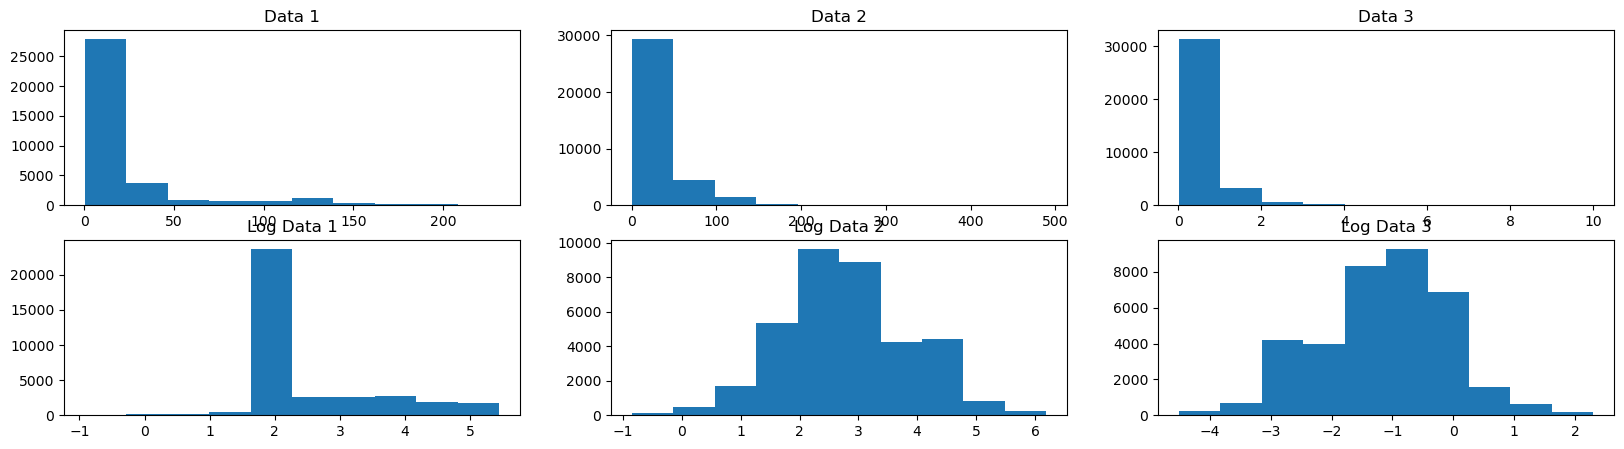

In [27]:
# 绘制分布直方图
import matplotlib.pyplot as plt
import numpy as np

ori_data = torch.load(os.path.join(save_path, "data.pt"))

log_data = torch.log(ori_data + 1e-8)

fig, axs = plt.subplots(2, 3, figsize=(20, 5))

for i in range(3):
    axs[0, i].hist(ori_data[:, i].numpy(), bins=10)
    axs[0, i].set_title(f"Data {i + 1}")
    
    axs[1, i].hist(log_data[:, i].numpy(), bins=10)
    axs[1, i].set_title(f"Log Data {i + 1}")
        
plt.show()


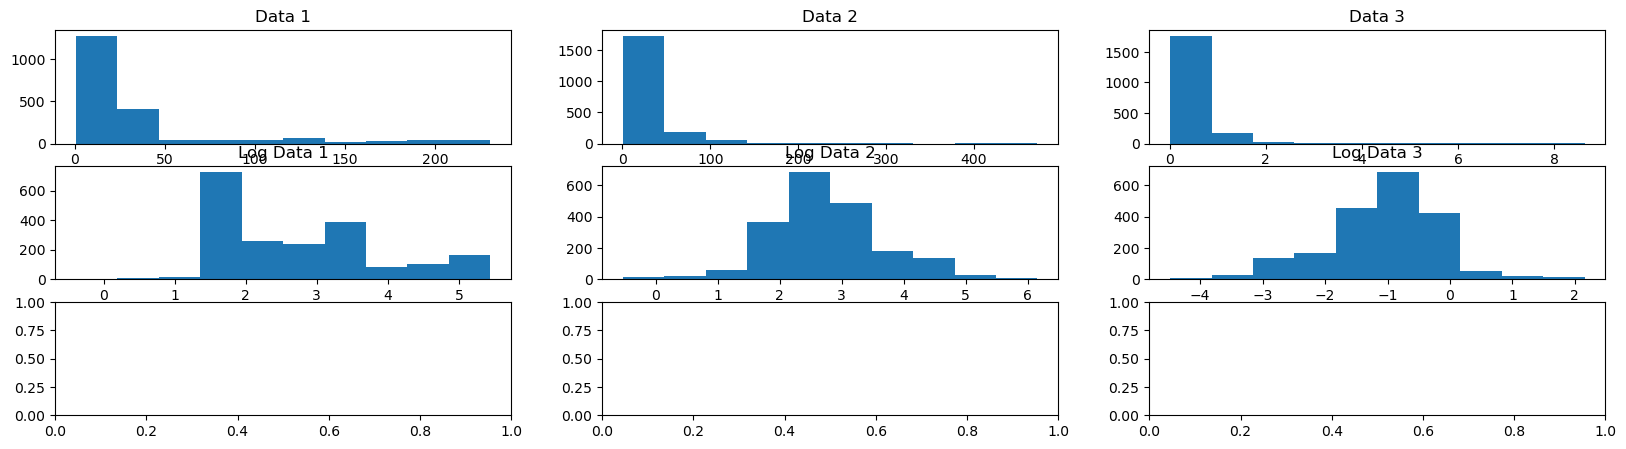

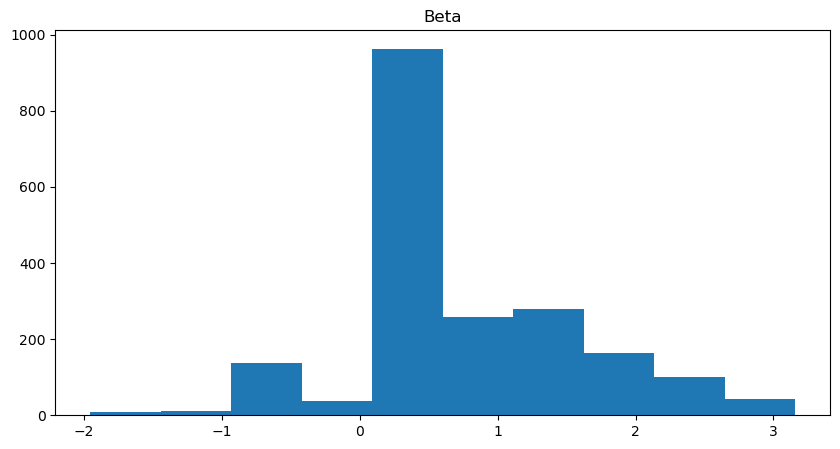

In [28]:
# 根据β的数值分布，进行分层采样

beta = torch.load(os.path.join(save_path, "beta.pt"))

# 计算beta的均值和方差，从而进行分层采样
mean_beta = beta.mean()
std_beta = beta.std()

# 分层采样
# 从 <mean - k*std, mean + k*std> 中采样, 采样n个
# 从其他区间中采样，采样n个
sample_indices = []
n= 1000
k = 2

beta_indices_outer = np.where((beta < mean_beta - k * std_beta) | (beta > mean_beta + k * std_beta))[0]
beta_indices_inner = np.where((beta >= mean_beta - k * std_beta) & (beta <= mean_beta + k * std_beta))[0]

np.random.shuffle(beta_indices_outer)
np.random.shuffle(beta_indices_inner)

sample_indices.extend(beta_indices_outer[:n])
sample_indices.extend(beta_indices_inner[:n])

# 保存对应的数据：(chi, Stilda, r) -> beta
sample_data = ori_data[sample_indices]
sample_beta = beta[sample_indices]

# 对数化数据
log_data = torch.log(sample_data + 1e-8)

# 绘制分布直方图
fig, axs = plt.subplots(3, 3, figsize=(20, 5))

for i in range(3):
    axs[0, i].hist(sample_data[:, i].numpy(), bins=10)
    axs[0, i].set_title(f"Data {i + 1}")
    
    axs[1, i].hist(log_data[:, i].numpy(), bins=10)
    axs[1, i].set_title(f"Log Data {i + 1}")
    
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.hist(sample_beta.numpy(), bins=10)
axs.set_title("Beta")
plt.show()

# 保存数据
torch.save(sample_data, os.path.join(save_path, "sample_data.pt"))
torch.save(sample_beta, os.path.join(save_path, "sample_beta.pt"))


In [29]:
# 利用一个简单的神经网络进行拟合

# import torch.nn as nn
# import torch.optim as optim

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(3, 10)
#         self.fc2 = nn.Linear(10, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
# net = Net()

# # 定义损失函数和优化器
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# # 加载数据
# data = torch.load(os.path.join(save_path, "sample_data.pt"))
# beta = torch.load(os.path.join(save_path, "sample_beta.pt"))

# # 自然对数化数据
# data = torch.log(data + 1e-8)

# # 训练
# for epoch in range(1000):
#     optimizer.zero_grad()
#     output = net(data)
#     loss = criterion(output, beta)
#     loss.backward()
#     optimizer.step()
    
#     if epoch % 100 == 0:
#         print(f"Epoch: {epoch}, Loss: {loss.item()}")
        
# print("Finished Training")

# # 保存模型
# torch.save(net.state_dict(), os.path.join(save_path, "model.pt"))

In [30]:
# 预测，加载完整数据
# data = torch.load(os.path.join(save_path, "data.pt"))
# beta = torch.load(os.path.join(save_path, "beta.pt"))

# # 自然对数化数据
# data = torch.log(data + 1e-8)

# # 加载模型
# net = Net()
# # model_path = "/home/lnhang/Final_cases/data_loader/PH_1p0"
# model_path = "/home/lnhang/Final_cases/data_loader/S809_14degree_Re2e6"
# net.load_state_dict(torch.load(os.path.join(model_path, "model.pt")))

# # 预测
# output = net(data)

# # 保存预测结果到path,保存为txt文件
# output_path = os.path.join(path, "output.txt")
# with open(output_path, "w") as f:
#     for i in range(len(output)):
#         f.write(f"{output[i].item()}\n")

# show_velocity_distribution(output, internal_coordinates, triangle)
# show_velocity_distribution(beta, internal_coordinates, triangle)